In [1]:
%matplotlib widget

In [1]:
greyscale=['#000000','#000000','#0F0F0F','#1F1F1F','#2E2E2E','#3D3D3D','#4D4D4D','#5C5C5C','#6B6B6B','#7A7A7A','#8A8A8A','#999999','#A8A8A8','#B8B8B8','#C7C7C7','#D6D6D6','#E6E6E6','#F5F5F5']
colors_g=['#001755','#002B95','#0036B3','#1A54D8','#3566DF','#4F79E5','#84A0F0','#9EB4F5']
#['#D9008E','#0000D2','#8400D6','#0048D1','#00C6CF','#21E121','#B5F23C','#3900D4']

In [2]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA,SparsePCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
from ephysvibe.task import task_constants
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
seed=2024

### Define functions

In [3]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [4]:
def compute_pca(x, n_comp=50):
    model = PCA(n_components=n_comp).fit(x.T)
    C = model.components_
    pc_s = C @ x
    return model, pc_s

### Read data

In [5]:
# Load data
time_before=500
n_test=1
start=-200
end_test = n_test*450+200
end=450+200+200+end_test
# Define epochs
test1_st =200+450+400
test2_st = test1_st+450
test3_st = test2_st+450
test4_st = test3_st+450
test5_st = test4_st+450
idx_f = np.arange(0,200,2)
idx_s = np.arange(200,200+450,2)
idx_d = np.arange(200+450,test1_st,2)
idx_t1 = np.arange(test1_st,test2_st,2)
idx_t2 = np.arange(test2_st,test3_st,2)
idx_t3 = np.arange(test3_st,test4_st,2)
idx_t4 = np.arange(test4_st,test5_st,2)
idx_aftert = np.arange(test2_st,end-start,2)

In [6]:
end-start

1700

In [7]:
len(colors_g)

8

In [8]:
t_epochs = {'fixation':idx_f,'sample':idx_s,'delay':idx_d,'test1':idx_t1,'test off':idx_aftert}#,'test2':idx_t2,'test3':idx_t3,'test4':idx_t4
colors = {'fixation':colors_g[0],'sample':colors_g[1],'delay':colors_g[2],'test1':colors_g[3],'test2':colors_g[4],'test3':colors_g[5],'test4':colors_g[6],'test off':colors_g[-1]}#
colors_neu = {'fixation':greyscale[0],'sample':greyscale[2],'delay':greyscale[5],'test1':greyscale[8],'test2':greyscale[10],'test3':greyscale[13],'test4':greyscale[16],'test off':greyscale[17]}#

In [9]:
basepath='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/pca/data/' 

In [10]:
n_comp=100
pc_areas = {}
for area in ['v4','pfc']:#'lip',
    neurons_fr_read=from_python_hdf5(load_path=basepath+area+'/include_non_match/'+area+'_win50_test'+str(n_test)+'_wnonmatch_min15tr_pca.h5')# include_non_match/  _wnonmatch_min10tr
    neurons_fr = []
    for asc in neurons_fr_read:
        fr = asc["fr"]
        if fr is not None:
            fr_concat = np.concatenate(fr,axis=0)
            neurons_fr.append(fr_concat)
    neurons_fr = np.array(neurons_fr)
    print('%s %d'%(area,neurons_fr.shape[0]))
    model,pc_s = compute_pca(neurons_fr,n_comp=n_comp)
    pc_areas[area] = {'fr':neurons_fr,'model':model,'pc':pc_s,'n_neurons':neurons_fr.shape[0]}


v4 933
pfc 1655


(8500,)

In [11]:
pcr = LinearRegression()

In [14]:
x = pc_areas['pfc']['pc'][:15].T
y = pc_areas['v4']['fr'][:100].T

In [15]:
rng = np.random.RandomState(seed)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y,train_size=0.7, random_state=rng)

In [17]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

In [23]:
scores = cross_val_score(pcr, x, y, cv=kf)
pred = cross_val_predict(pcr, x, y, cv=kf)

In [20]:
scores

array([0.604962  , 0.60591313, 0.6018569 , 0.60234096, 0.60540748])

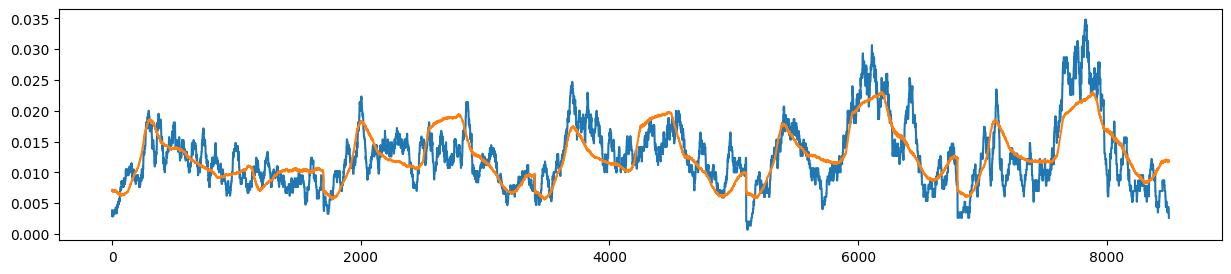

In [32]:
for i in range(1):
    plt.subplots(figsize=(15,3))
    plt.plot(y[:,i])
    plt.plot(pred[:,i])

In [25]:
pred.shape

(8500, 100)

In [22]:
x_train.shape

(5950, 15)

In [114]:
pcr.fit(x_test,y_test)

LinearRegression()

In [115]:
print(pcr.score(x_test,y_test))
#print(pcr.score(x_test,y_test))

0.6078475118337753


In [78]:
y_pred = pcr.predict(x_train)

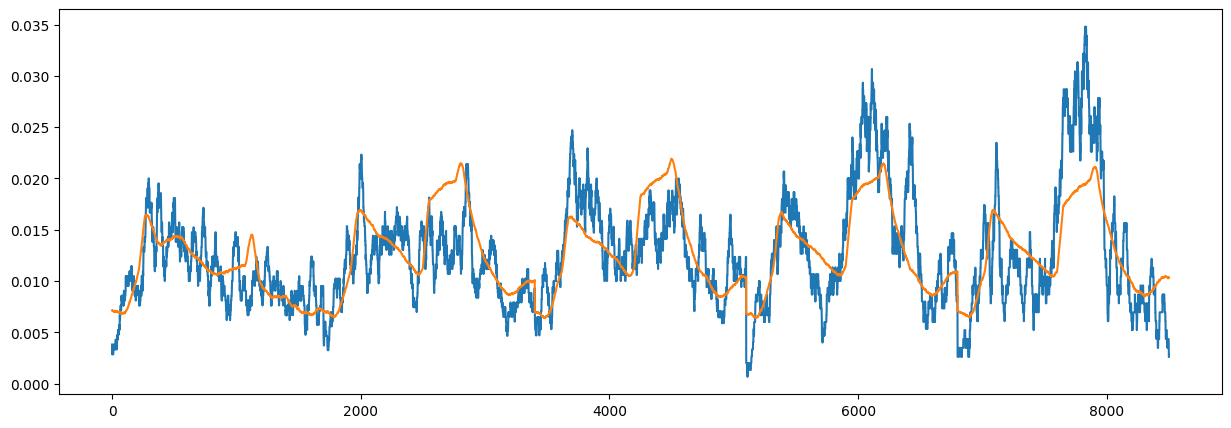

In [79]:
plt.subplots(figsize=(15,5))
plt.plot(y[:,0])
plt.plot(y_pred[:,0])

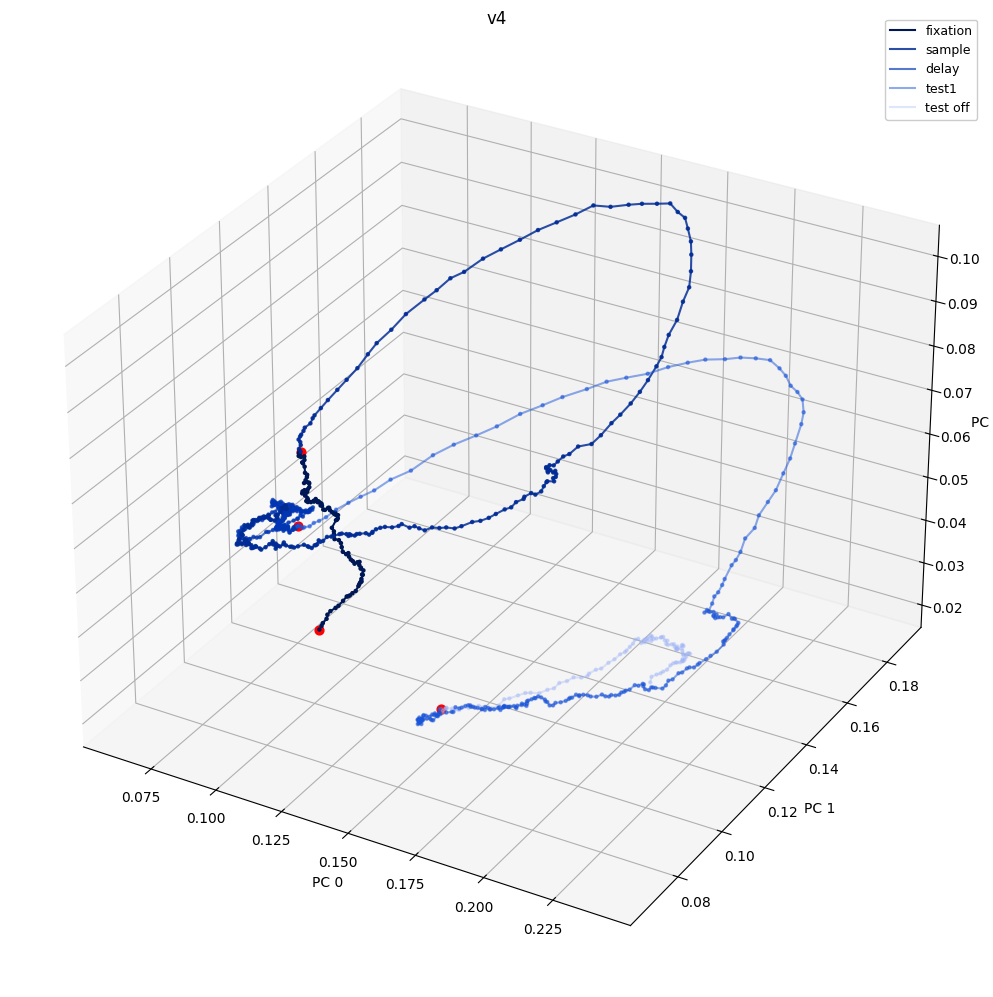

In [10]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,end-start)
    mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
    pca_tools.plot_pc_3d(mean_pc_s,colors,t_epochs,key,figsize=(10,10))

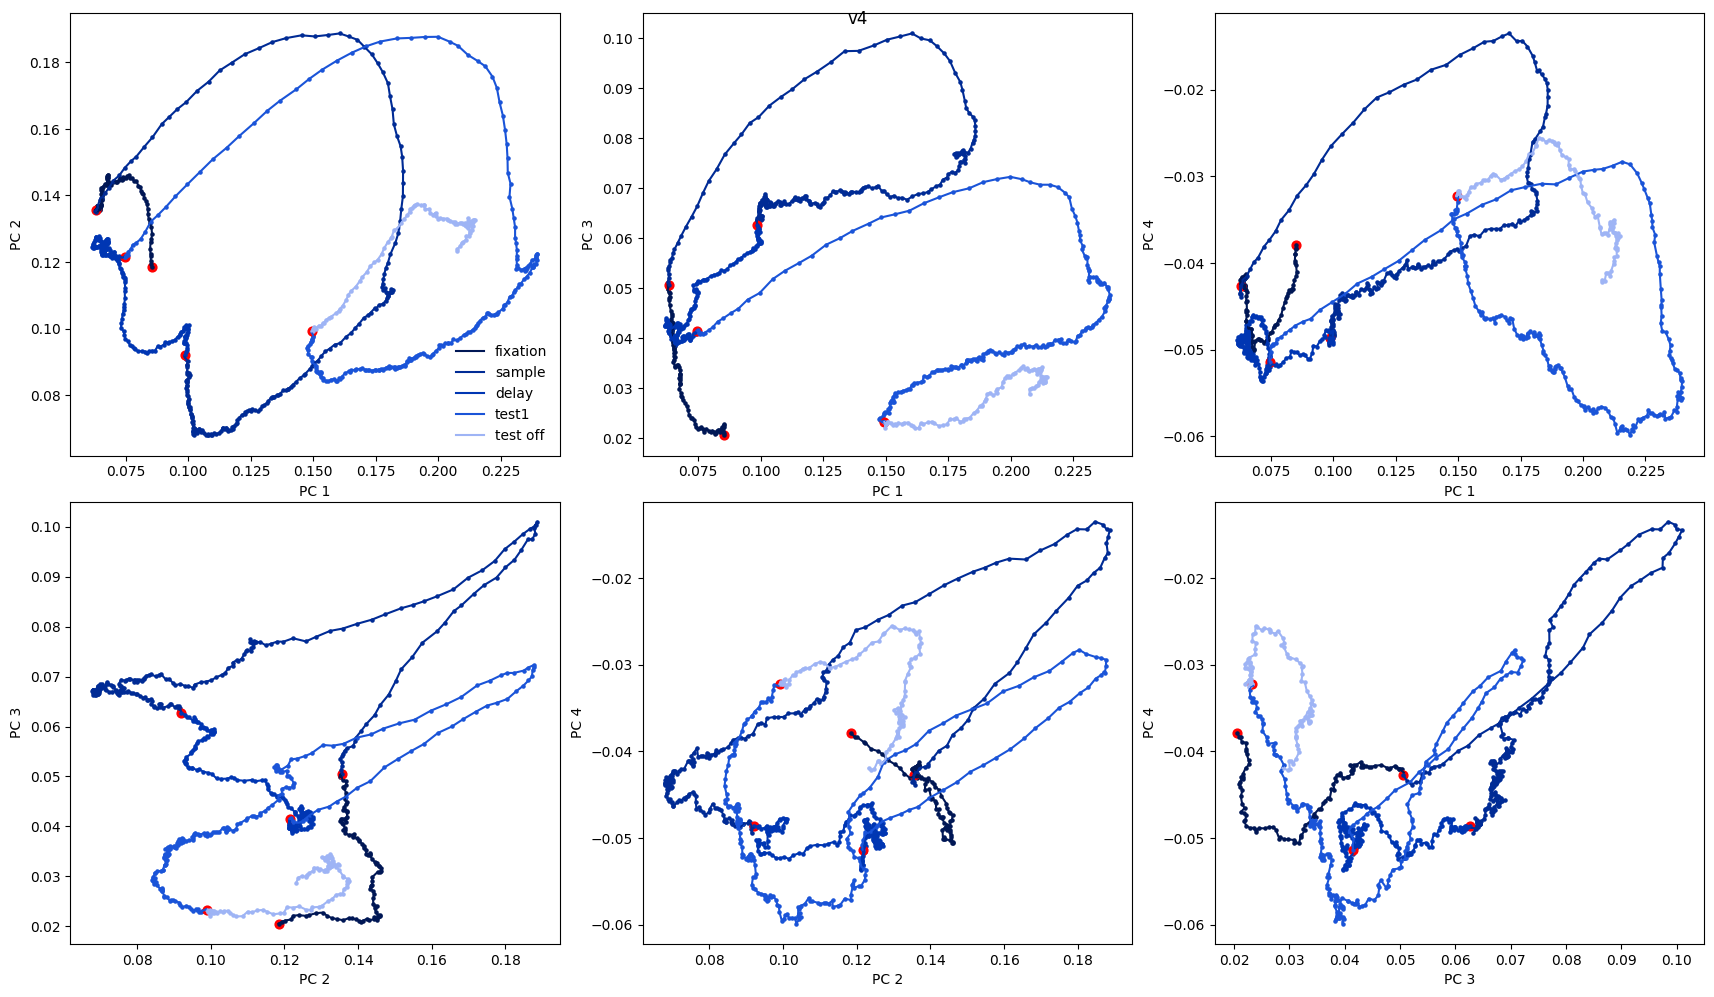

In [11]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,end-start)
    mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
    pca_tools.plot_pc(mean_pc_s,colors,t_epochs,key,figsize=(17,10))

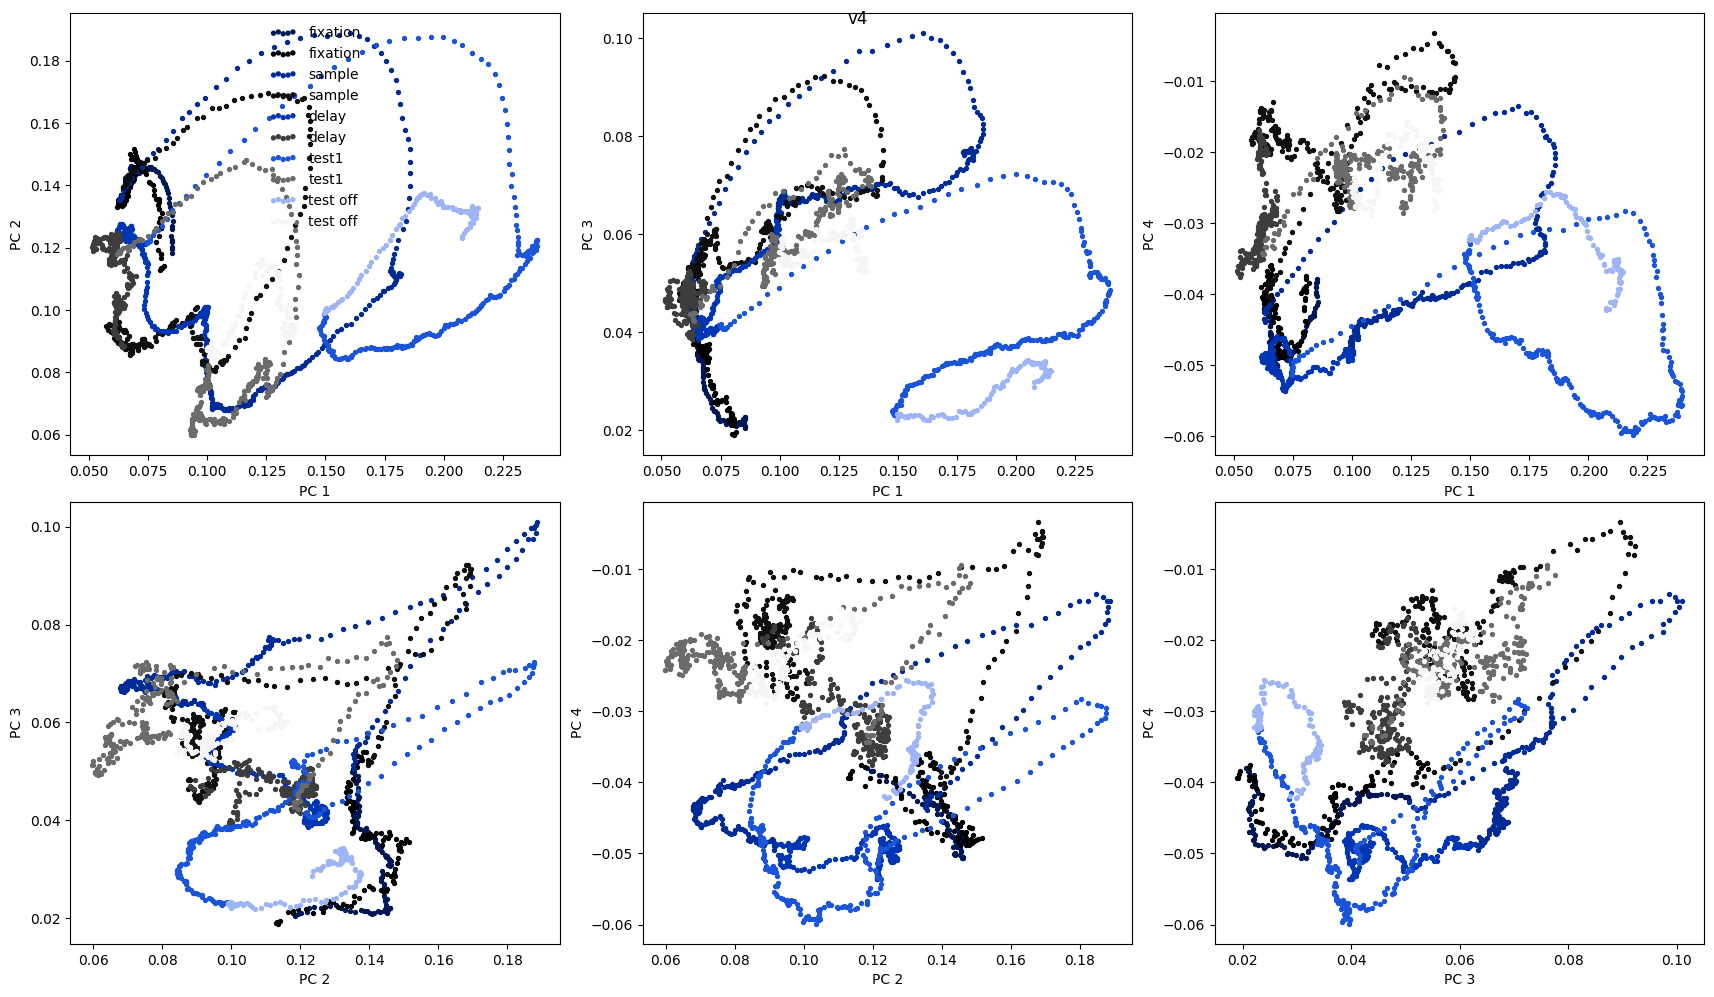

In [12]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,end-start)
    mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
    pca_tools.plot_pc_neu(mean_pc_s,reshape_pc_s[:,0],colors,colors_neu,t_epochs,key,figsize=(17,10))

In [13]:
samples={
    "o0_c0": 0,
    "o1_c1": 1,
    "o1_c5": 2,
    "o5_c5": 3,
    "o5_c1": 4,
    
}

In [14]:
colors_s = []
for i_sample in samples.keys():
    colors_s.append({'fixation': task_constants.PALETTE_B1[i_sample],
    'sample': task_constants.PALETTE_B1[i_sample],
    'delay': task_constants.PALETTE_B1[i_sample],
    'test1': task_constants.PALETTE_B1[i_sample],
    'test2': task_constants.PALETTE_B1[i_sample],
    'test3': task_constants.PALETTE_B1[i_sample],
    'test4': task_constants.PALETTE_B1[i_sample],
    'test off': task_constants.PALETTE_B1[i_sample]})

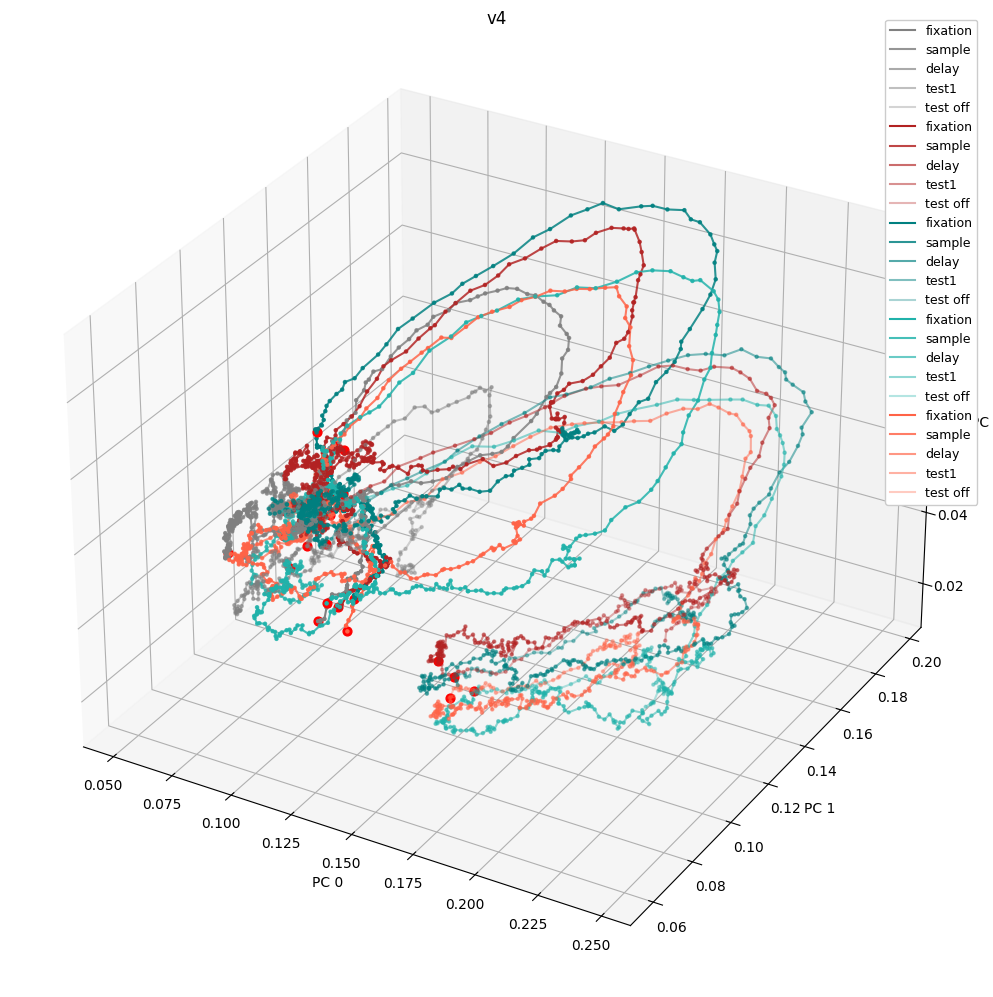

In [15]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,end-start)
    fig, ax = plt.subplots(
        figsize=(10,10), sharey=True, sharex=True, subplot_kw={"projection": "3d"}
    )
    for s in range(5):
        pca_tools.plot_pc_3d(reshape_pc_s[:,s],colors_s[s],t_epochs,key,figsize=(17,10),fig=fig,ax=ax)

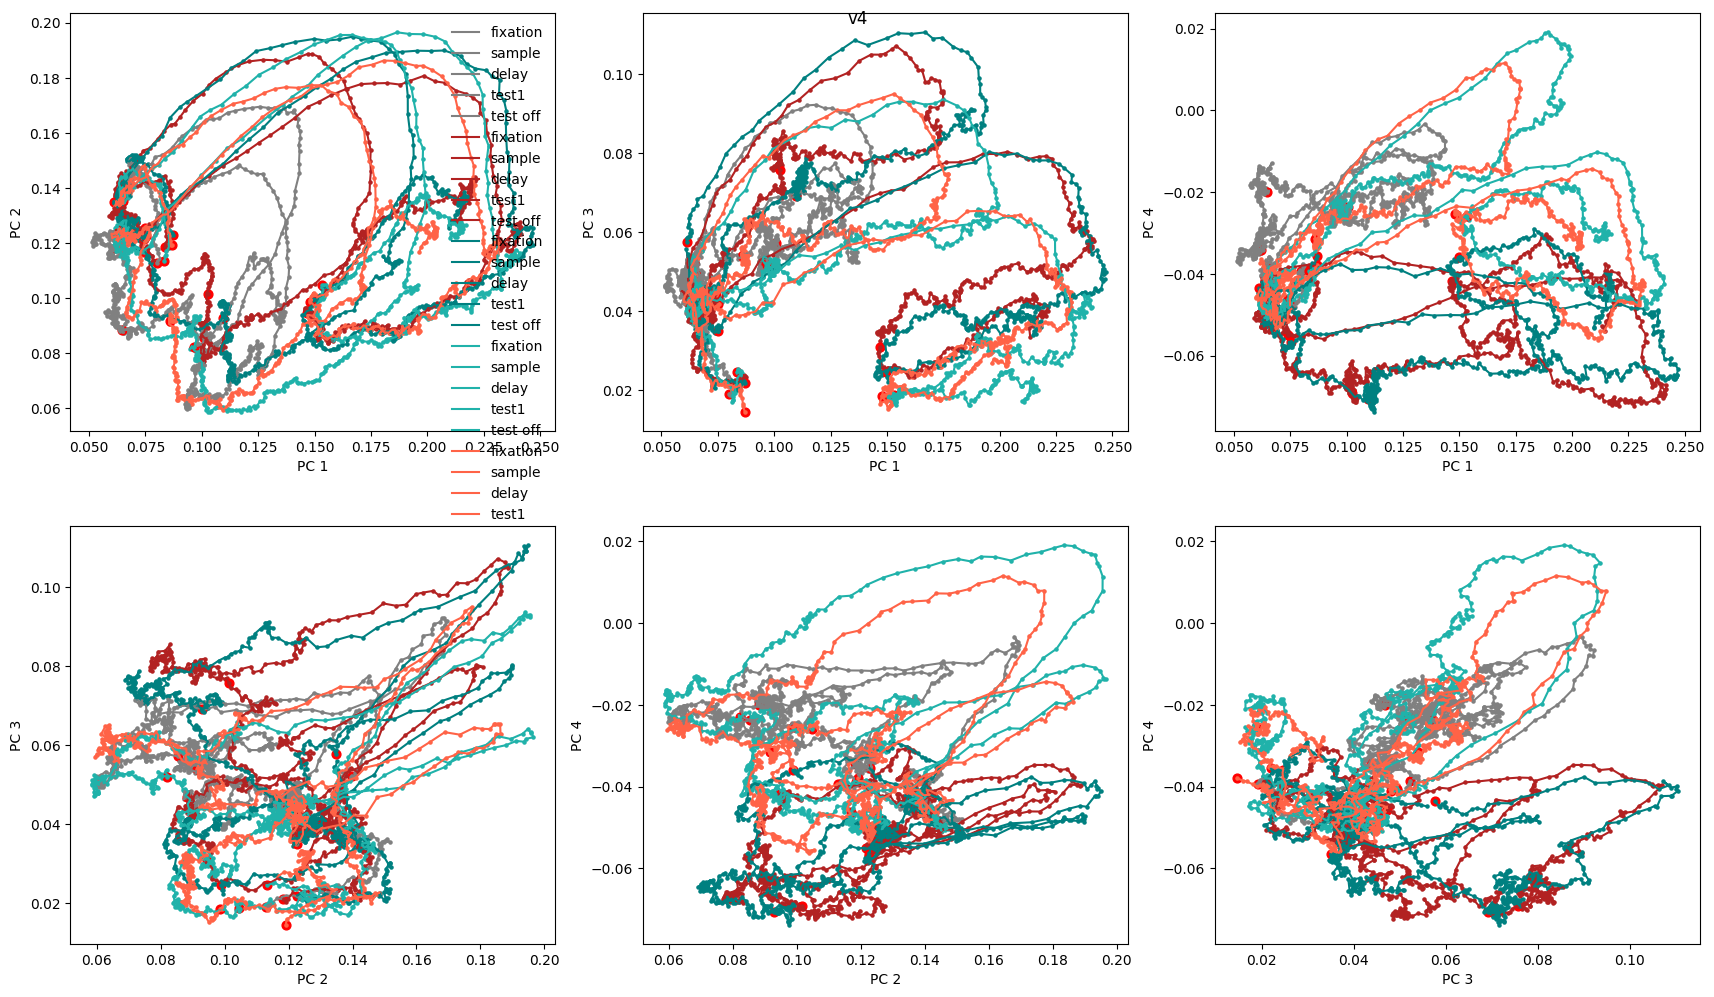

In [16]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,end-start)
    fig, ax = plt.subplots(2, 3, figsize=(17,10))
    for s in range(5):
        pca_tools.plot_pc(reshape_pc_s[:,s],colors_s[s],t_epochs,key,figsize=(17,10),fig=fig,ax=ax)

v4: 11 components to explain 80% of the variance


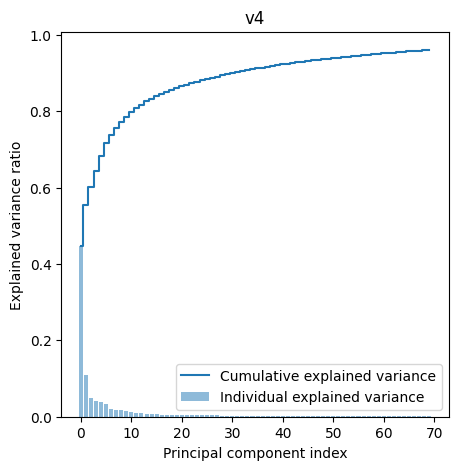

In [17]:
fig, ax = plt.subplots(figsize=(5,5))
for key in pc_areas:
    pca_tools.plot_explained_var(pc_areas[key]['model'],figsize=(5,5),area=key,fig=fig,ax=ax)

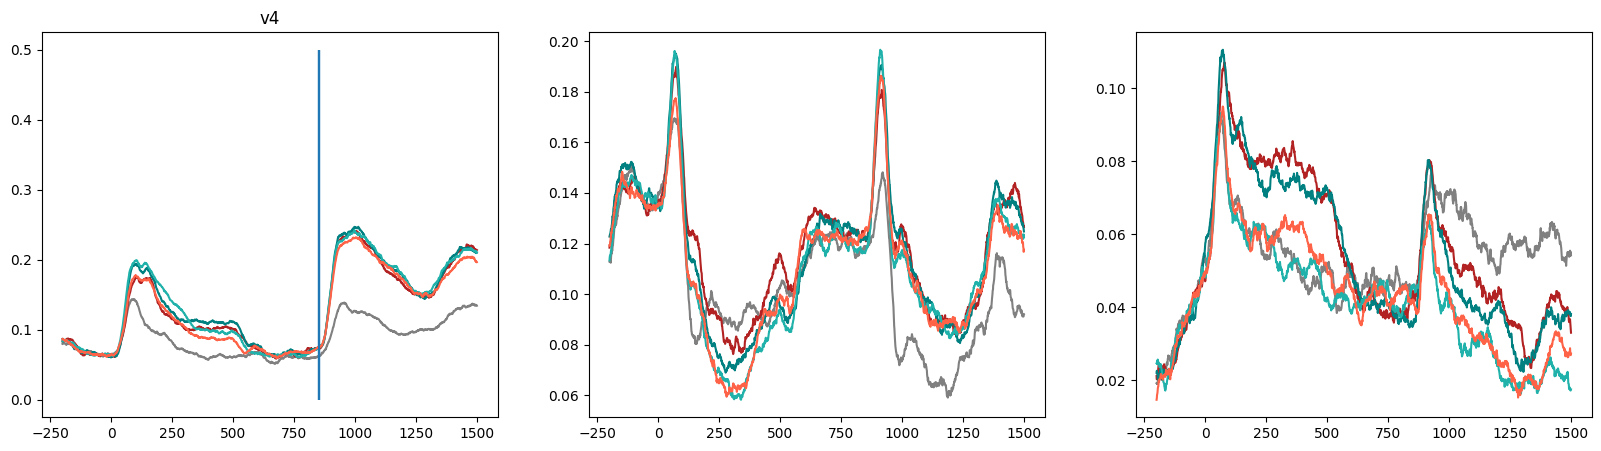

In [18]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,end-start)
    f,ax=plt.subplots(1,3,figsize=(20,5))
    for i_sample in samples.keys():
        
        ax[0].plot(range(start,end),reshape_pc_s[0,samples[i_sample],:],color=task_constants.PALETTE_B1[i_sample])
        ax[0].vlines(850,0,0.5)
        ax[1].plot(range(start,end),reshape_pc_s[1,samples[i_sample],:],color=task_constants.PALETTE_B1[i_sample])
        ax[2].plot(range(start,end),reshape_pc_s[2,samples[i_sample],:],color=task_constants.PALETTE_B1[i_sample])
        ax[0].set(title=key)
